# Create a feature engineering pipeline

In Section 1, you tabularized a sales time series dataset to forecast sales for the next week.

In this assignment, your task is to line up those feature engineering steps within a pipeline to directly obtain the features from the input data and then forecast sales using Lasso.

The most straightforward method is probably to use the open-source library Feature-engine. But you are welcome to use other libraries, code your transformers manually, or, why not, code our own pipeline?

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [71]:
# imports

import pandas as pd
import matplotlib.pyplot as plt

from feature_engine.creation import CyclicalFeatures

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline

In [39]:
# load weekly sales dataset

# Adjust the following function based on where 
# you stored the dataset
filename = "online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["invoice_date", "United Kingdom"],
    parse_dates=["invoice_date"],
    index_col=["invoice_date"],
)

df.columns = ['sales']

df.head()

,sales
invoice_date,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


## Plot time series

<Axes: xlabel='invoice_date'>

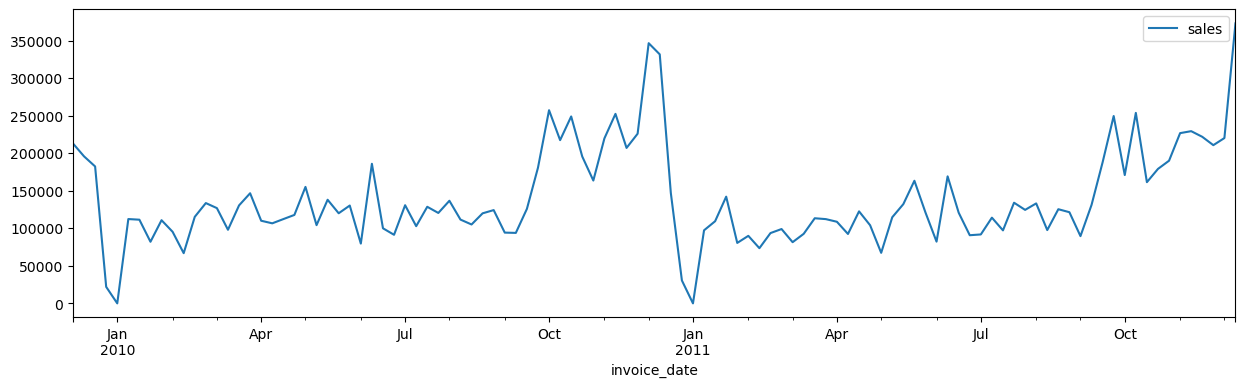

In [7]:
df.plot(figsize=[15, 4])

## Missing Timestamps

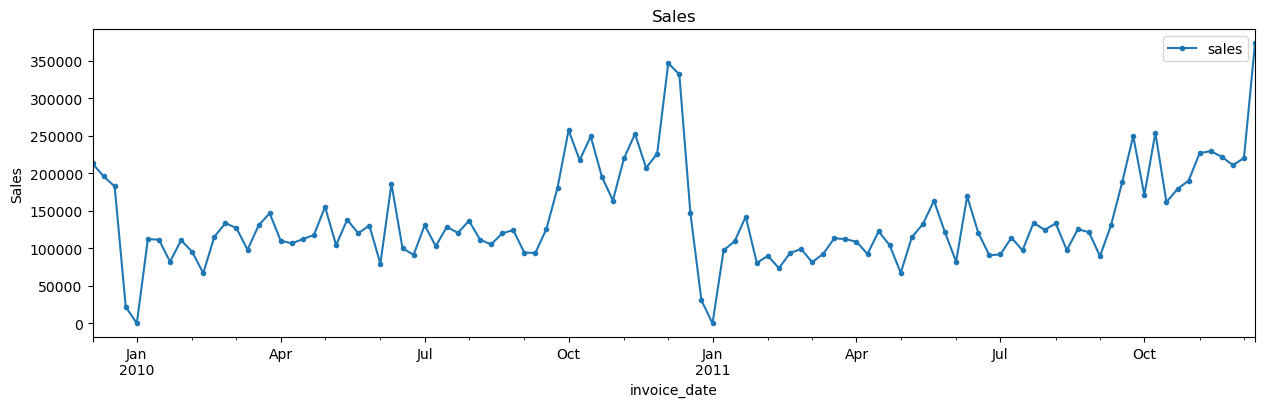

In [10]:
# Introduce the missing timestamps.
# Note that we capture this in a different dfframe.
df_ = df.asfreq("1W")

# Apply the forward fill method.
df_imputed = df_.fillna(method="ffill")

# plot the time series.
ax = df_.plot(linestyle="-", marker=".", figsize=[15, 4])

# plot the imputed values on top, in red.
df_imputed[df_.isnull()].plot(ax=ax, legend=None, marker=".", color="r")

# Add title.
plt.title("Sales")

# the y axis label
plt.ylabel("Sales")

plt.show()

## Seasonality

we will check of there is any monthly or weeks of the month "wom" seasonality

Text(0, 0.5, 'Sales')

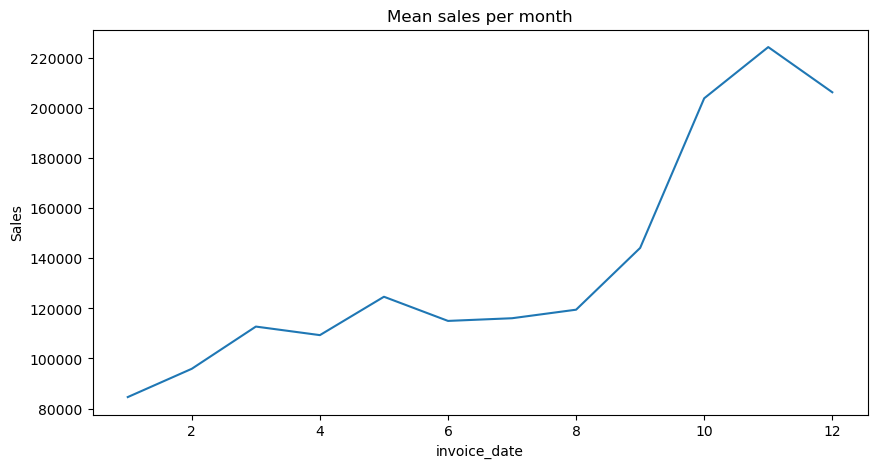

In [11]:
# Plot the average sales per month.

month = df.index.month

df.groupby(month)["sales"].mean().plot(figsize=(10, 5))
plt.title("Mean sales per month")
plt.ylabel("Sales")

Text(0, 0.5, 'Sales')

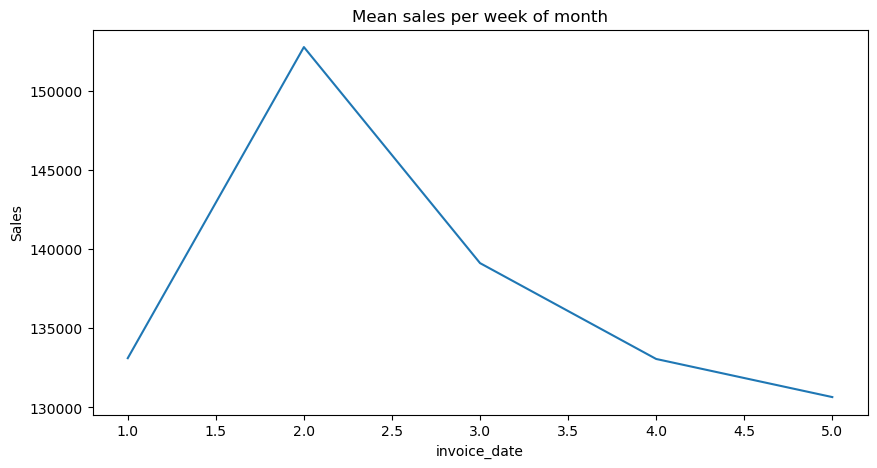

In [12]:
# Plot the average sales for every 1,2,3,4 and 5 week of a month.

wom = (df.index.day - 1) // 7 + 1

df.groupby(wom)["sales"].mean().plot(figsize=(10, 5))
plt.title("Mean sales per week of month")
plt.ylabel("Sales")

## Feature engineering

These are the feature engineering steps that you need to fit into a pipeline:

- Datetime features: Create the feature **month** from the timestamp.
- Cyclical features: transform the month with the sine and cosine functions.
- Lag features: Create the feature lag-1 by lagging 1 week of data.
- Window features: take the min, max and average sales values in the past 2 and 4 weeks of data.
- Drop missing data.

First set up suitable transformers / transformations and make sure they work.

In [15]:
# Create the feature month from the timestamp.
# month of the year

df["month"] = df.index.month
df['wom'] = (df.index.day -1) //7 + 1


df.head()

,sales,month,wom
invoice_date,,,
2009-12-06,213000.35,12,1
2009-12-13,195810.04,12,2
2009-12-20,182396.74,12,3
2009-12-27,22007.77,12,4
2010-01-03,0.00,1,1


In [16]:
# Transform the month with the sine and cosine functions

cyclical = CyclicalFeatures(
    variables=["month", "wom"],  # The features to transform.
    drop_original=False,  # Whether to drop the original features.
)

df = cyclical.fit_transform(df)

df.head()

,sales,month,wom,month_sin,month_cos,wom_sin,wom_cos
invoice_date,,,,,,,
2009-12-06,213000.35,12,1,-2.449294e-16,1.000000,0.951057,0.309017
2009-12-13,195810.04,12,2,-2.449294e-16,1.000000,0.587785,-0.809017
2009-12-20,182396.74,12,3,-2.449294e-16,1.000000,-0.587785,-0.809017
2009-12-27,22007.77,12,4,-2.449294e-16,1.000000,-0.951057,0.309017
2010-01-03,0.00,1,1,5.000000e-01,0.866025,0.951057,0.309017


In [17]:
# Create the feature lag-1 by lagging 1 week of data.
# Sales the previous week.

tmp = pd.DataFrame(df["sales"].shift(freq="1W"))

# Name for the new variable.
tmp.columns = ["sales_lag_1"]

# Add the variable to the original df.
df = df.merge(tmp, left_index=True, right_index=True, how="left")

df.head()

,sales,month,wom,month_sin,month_cos,wom_sin,wom_cos,sales_lag_1
invoice_date,,,,,,,,
2009-12-06,213000.35,12,1,-2.449294e-16,1.000000,0.951057,0.309017,NaN
2009-12-13,195810.04,12,2,-2.449294e-16,1.000000,0.587785,-0.809017,213000.35
2009-12-20,182396.74,12,3,-2.449294e-16,1.000000,-0.587785,-0.809017,195810.04
2009-12-27,22007.77,12,4,-2.449294e-16,1.000000,-0.951057,0.309017,182396.74
2010-01-03,0.00,1,1,5.000000e-01,0.866025,0.951057,0.309017,22007.77


In [18]:
# Here we take the average, maximum, and minimum values
# of the previous 2 and 4 weeks.

for window in [2, 4]:
    
    tmp = df["sales"].rolling(window=window).agg(["mean", "max", "min"]).shift(1)

    tmp.columns = [f"sales_{window}_{func}" for func in ["mean", "max", "min"]]
    
    df = df.merge(tmp, left_index=True, right_index=True, how="left")

# view of the result
df.head(10)

,sales,month,wom,month_sin,month_cos,wom_sin,wom_cos,sales_lag_1,sales_2_mean,sales_2_max,sales_2_min,sales_4_mean,sales_4_max,sales_4_min
invoice_date,,,,,,,,,,,,,,
2009-12-06,213000.350,12,1,-2.449294e-16,1.000000,9.510565e-01,0.309017,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-13,195810.040,12,2,-2.449294e-16,1.000000,5.877853e-01,-0.809017,213000.350,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-20,182396.740,12,3,-2.449294e-16,1.000000,-5.877853e-01,-0.809017,195810.040,204405.1950,213000.350,195810.040,NaN,NaN,NaN
2009-12-27,22007.770,12,4,-2.449294e-16,1.000000,-9.510565e-01,0.309017,182396.740,189103.3900,195810.040,182396.740,NaN,NaN,NaN
2010-01-03,0.000,1,1,5.000000e-01,0.866025,9.510565e-01,0.309017,22007.770,102202.2550,182396.740,22007.770,153303.72500,213000.35,22007.770
2010-01-10,112318.850,1,2,5.000000e-01,0.866025,5.877853e-01,-0.809017,0.000,11003.8850,22007.770,0.000,100053.63750,195810.04,0.000
2010-01-17,111460.470,1,3,5.000000e-01,0.866025,-5.877853e-01,-0.809017,112318.850,56159.4250,112318.850,0.000,79180.84000,182396.74,0.000
2010-01-24,82065.331,1,4,5.000000e-01,0.866025,-9.510565e-01,0.309017,111460.470,111889.6600,112318.850,111460.470,61446.77250,112318.85,0.000
2010-01-31,110790.591,1,5,5.000000e-01,0.866025,-2.449294e-16,1.000000,82065.331,96762.9005,111460.470,82065.331,76461.16275,112318.85,0.000


In [19]:
# Drop missing data.
df.isnull().sum() / len(df)


sales           0.000000
month           0.000000
wom             0.000000
month_sin       0.000000
month_cos       0.000000
wom_sin         0.000000
wom_cos         0.000000
sales_lag_1     0.009434
sales_2_mean    0.018868
sales_2_max     0.018868
sales_2_min     0.018868
sales_4_mean    0.037736
sales_4_max     0.037736
sales_4_min     0.037736
dtype: float64

In [20]:
df.dropna(inplace=True)

In [9]:
# Drop original time series

## ML Workflow

- Load the data again.
- Split the data into a suitable train and test set.
- Align all feature engineering steps in a pipeline.
- Create the features.
- Train a model.
- Evaluate the model.

In [62]:
# load weekly sales dataset

# adjust the following function based on where 
# you stored the dataset
filename = "online_retail_dataset.csv"

df = pd.read_csv(
    filename,
    usecols=["invoice_date", "United Kingdom"],
    parse_dates=["invoice_date"],
    index_col=["invoice_date"],
)

df.columns = ['sales']
df.sort_index(inplace=True)
df.head()

,sales
invoice_date,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


In [75]:
# pipeline functions

def dtf(df):
    df["month"] = df.index.month
    df['wom'] = (df.index.day -1) //7 + 1
    return df

def lagf(df):
    tmp = pd.DataFrame(df["sales"].shift(freq="1W"))

    # Name for the new variable.
    tmp.columns = ["sales_lag_1"]

    # Add the variable to the original df.
    df = df.merge(tmp, left_index=True, right_index=True, how="left")
    return df

def winf(df):
    for window in [2, 4]:
    
        tmp = df["sales"].rolling(window=window).agg(["mean", "max", "min"]).shift(1)

        tmp.columns = [f"sales_{window}_{func}" for func in ["mean", "max", "min"]]

        df = df.merge(tmp, left_index=True, right_index=True, how="left")
    return df


def imputer(df):
    df.dropna(inplace=True)
    return df

def drop_ts(df):
    df.drop('sales', axis=1, inplace=True)
    return df




In [77]:
class DateTransformer:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X["month"] = X.index.month
        X['wom'] = (X.index.day - 1) // 7 + 1
        return X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

class LagFeatureExtractor:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        tmp = pd.DataFrame(X["sales"].shift(freq="1W"))
        tmp.columns = ["sales_lag_1"]
        X = X.merge(tmp, left_index=True, right_index=True, how="left")
        return X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

class WindowFeatureExtractor:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        for window in [2, 4]:
            tmp = X["sales"].rolling(window=window).agg(["mean", "max", "min"]).shift(1)
            tmp.columns = [f"sales_{window}_{func}" for func in ["mean", "max", "min"]]
            X = X.merge(tmp, left_index=True, right_index=True, how="left")
        return X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

class DataImputer:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.dropna(inplace=True)
        return X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

class TargetDropper:
    def fit(self, X, y=None):
        return self

    def transform(self, X):
        X.drop('sales', axis=1, inplace=True)
        return X

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)


In [78]:
dtf = DateTransformer()
lagf = LagFeatureExtractor()
winf = WindowFeatureExtractor()
imputer = DataImputer()
drop_ts = TargetDropper()

pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclical),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

In [79]:
df = df.asfreq("1D").fillna(method="ffill")

In [80]:
df.index.min(), df.index.max()

(Timestamp('2009-12-06 00:00:00', freq='D'),
 Timestamp('2011-12-11 00:00:00', freq='D'))

Due to our 1W lag feature, we need data about the pollutant information at least 1W  before the first forecasting point in the test set to create input features.

Thus, the test set must contain the first forecasting point plus the previous 1W.

In [81]:
# The offset for the test set
pd.Timestamp("2011-10-11") - pd.offsets.Week(1)

Timestamp('2011-10-04 00:00:00')

In [83]:
# Split the data in time.
# input data
X_train = df[df.index < "2011-10-11"]
X_test = df[df.index >= pd.Timestamp("2011-10-11") - pd.offsets.Week(1)]

# target
y_train = df[df.index < "2011-10-11"]["sales"]
y_test = df[df.index >= pd.Timestamp("2011-10-11") - pd.offsets.Week(1)][
    "sales"
]

In [84]:
# Let's check that we have the correct data span
# in the test set:

X_test.index.min(), X_test.index.max()

(Timestamp('2011-10-04 00:00:00', freq='D'),
 Timestamp('2011-12-11 00:00:00', freq='D'))

## Machine Learning

In [87]:
# Train the pipeline and create features
# for the train set:

X_train_t = pipe.fit_transform(X_train)
X_test_t = pipe.transform(X_test)


# Data with input features.
X_train_t.head()

/var/folders/5r/v4fyt44d0_9_mblbwj5pkj900000gn/T/ipykernel_19016/224276298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X["month"] = X.index.month
/var/folders/5r/v4fyt44d0_9_mblbwj5pkj900000gn/T/ipykernel_19016/224276298.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['wom'] = (X.index.day - 1) // 7 + 1
/var/folders/5r/v4fyt44d0_9_mblbwj5pkj900000gn/T/ipykernel_19016/224276298.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

,month,wom,sales_lag_1,sales_2_mean,sales_2_max,sales_2_min,sales_4_mean,sales_4_max,sales_4_min,month_sin,month_cos,wom_sin,wom_cos
invoice_date,,,,,,,,,,,,,
2009-12-13,12,2,213000.35,213000.35,213000.35,213000.35,213000.3500,213000.35,213000.35,-2.449294e-16,1.0,0.587785,-0.809017
2009-12-13,12,2,213000.35,213000.35,213000.35,213000.35,208702.7725,213000.35,195810.04,-2.449294e-16,1.0,0.587785,-0.809017
2009-12-13,12,2,213000.35,213000.35,213000.35,213000.35,204405.1950,213000.35,195810.04,-2.449294e-16,1.0,0.587785,-0.809017
2009-12-13,12,2,213000.35,213000.35,213000.35,213000.35,200107.6175,213000.35,195810.04,-2.449294e-16,1.0,0.587785,-0.809017
2009-12-13,12,2,213000.35,213000.35,213000.35,213000.35,195810.0400,195810.04,195810.04,-2.449294e-16,1.0,0.587785,-0.809017


In [88]:
y_train_t = y_train.loc[X_train_t.index]
y_test_t = y_test.loc[X_test_t.index]

In [90]:
# Performance of naive forecast

print("train rmse: ", mean_squared_error(
    y_train_t, X_train_t["sales_lag_1"], squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test_t, X_test_t["sales_lag_1"], squared=False,))

train rmse:  49000.36077994247
test rmse:  62076.664762133456


In [92]:
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train_t, y_train_t)

# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train_t, linear_model.predict(X_train_t), squared=False,))

print("test rmse: ",  mean_squared_error(
    y_test_t, linear_model.predict(X_test_t), squared=False,))

train rmse:  8506.79066377258
test rmse:  11294.165822868204


/Users/ahmadkhair/anaconda3/lib/python3.11/site-packages/sklearn/linear_model/_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.344e+12, tolerance: 7.903e+10
  model = cd_fast.enet_coordinate_descent(
